# Table 1 Experiments for 'Explaining RL Decisions with Trajectories': A Reproducibility Study

This file contains code used for generating results of the gridworld experiments.

In [1]:
# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [2]:
# # Four Rooms Environment

# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 11
# env_height = 11
# env = Environment(dim=(env_width, env_height),
# #                   starts=[(2, 0), (6, 2), (2,4), (5,5)],
#                   terminals={(0, 0): +1, (0, 10): +1, (4, 3): -1, (8, 2):-1, (2, 8):+1, (3, 6):-1, (7,7):-1, (10, 6):-1, (10, 4):+1, (10, 8):+1},
#                   obstacles=[[0, 5], [1, 5], [3, 5], [4, 5], [5, 0], [5, 2], [5, 3], [5, 4], [5, 5], [6, 5], [7, 5], [8, 5], [10, 5], [6, 6], [6, 7], [6, 9], [6, 10]],
#                   stoc=0.)

# env.render(title='Four Rooms')

# # Initialize the agent
# agent = Agent(env)

# #####

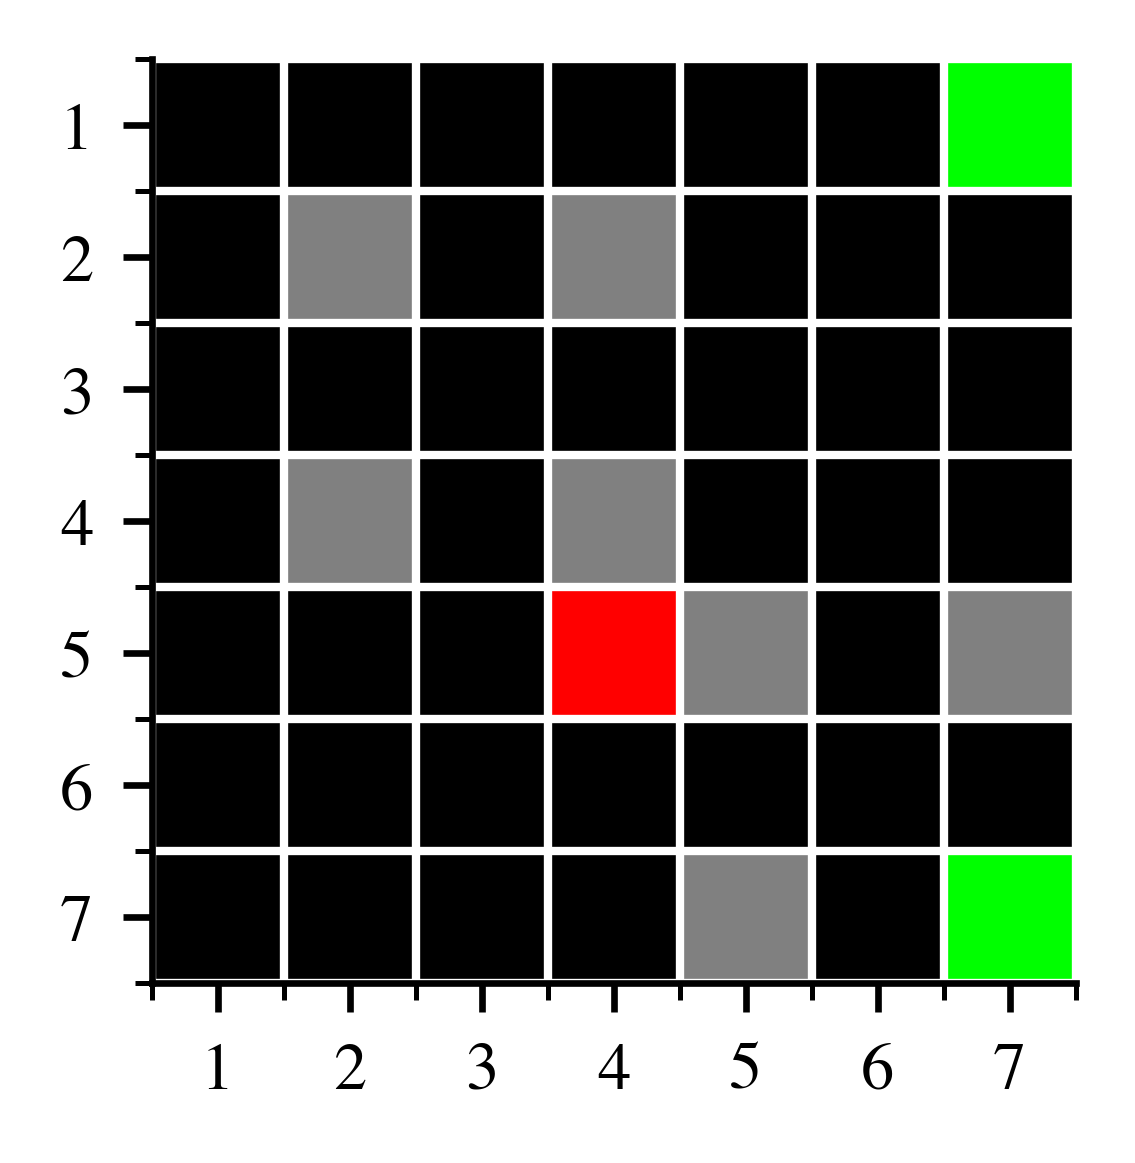

In [3]:
# # 7x7 Gridworld Environment

action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
reward_dict = {1:0, -1:1, -0.1:2, 0:3}

#####

# Environment Definition
env_width = 7
env_height = 7
env = Environment(dim=(env_width, env_height),
                  starts=[(2, 0), (6, 2), (2,4)],
                  terminals={(0, 6): +1, (6, 6): +1, (4, 3): -1},
                  obstacles=[[1, 1], [1, 3], [3, 1], [3, 3], [4,4], [6, 4], [4,6]],
                  stoc=0.)

env.render(title='7x7 Gridworld')

# Initialize the agent
agent = Agent(env)

#####

In [4]:
# # 5x5 Gridworld Environment
# action_dict = {0: 'LEFT', 1: 'UP', 2: 'RIGHT', 3: 'DOWN'}
# reward_dict = {1:0, -1:1, -0.1:2, 0:3}

# #####

# # Environment Definition
# env_width = 5
# env_height = 5
# env = Environment(dim=(env_width, env_height),
#                   starts=[(4, 4), (4, 2)],
#                   terminals={(0, 1): +1, (4, 4): -1},
#                   obstacles=[[3,2],[3,3]],
#                   stoc=0.)

# env.render(title='Gridworld')

# # Initialize the agent
# agent = Agent(env)

# #####

### Collecting offline trajectory data

In [5]:
# Generate offline data for the training
num_episodes_dyna = 2
num_agents_dyna = 5
max_traj_len = 10
num_pos_trajs = 50
num_neg_trajs = 10
offline_data = generate_offline_data(env, agent, num_episodes_dyna, num_agents_dyna, max_traj_len, num_pos_trajs, num_neg_trajs)

#####

Training 5 Agents


100%|██████████| 5/5 [00:00<00:00, 48.21it/s]

# POS TRAJs 1
# NEG TRAJs 1
# NEG TRAJs 2
# POS TRAJs 2
# POS TRAJs 3
# NEG TRAJs 3
# POS TRAJs 4
# POS TRAJs 5
# POS TRAJs 6
# NEG TRAJs 4
# POS TRAJs 7
# NEG TRAJs 5
# POS TRAJs 8
# NEG TRAJs 6
# POS TRAJs 9
# POS TRAJs 10
# NEG TRAJs 7
# NEG TRAJs 8
# NEG TRAJs 9
# NEG TRAJs 10
# POS TRAJs 11
# POS TRAJs 12
# POS TRAJs 13
# POS TRAJs 14
# POS TRAJs 15
# POS TRAJs 16
# POS TRAJs 17
# POS TRAJs 18
# POS TRAJs 19
# POS TRAJs 20
# POS TRAJs 21
# POS TRAJs 22
# POS TRAJs 23
# POS TRAJs 24
# POS TRAJs 25
# POS TRAJs 26
# POS TRAJs 27
# POS TRAJs 28
# POS TRAJs 29
# POS TRAJs 30
# POS TRAJs 31
# POS TRAJs 32
# POS TRAJs 33
# POS TRAJs 34
# POS TRAJs 35
# POS TRAJs 36
# POS TRAJs 37
# POS TRAJs 38
# POS TRAJs 39
# POS TRAJs 40
# POS TRAJs 41
# POS TRAJs 42
# POS TRAJs 43
# POS TRAJs 44
# POS TRAJs 45
# POS TRAJs 46
# POS TRAJs 47
# POS TRAJs 48
# POS TRAJs 49
# POS TRAJs 50
----------------------------
Number of trajectories generated:
+1 trajs: 50
-1 trajs: 10
----------------------------


In [6]:
## If you are planning to pickle these trajectories and use them instead of generating them every time...
# results_save_dir = './gridworld_results/grid_7by7/'
# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'wb') as f:
#     pickle.dump(offline_data, f)

# with open(os.path.join(results_save_dir, 'offline_traj.pkl'), 'rb') as f:
#     offline_data = pickle.load(f)

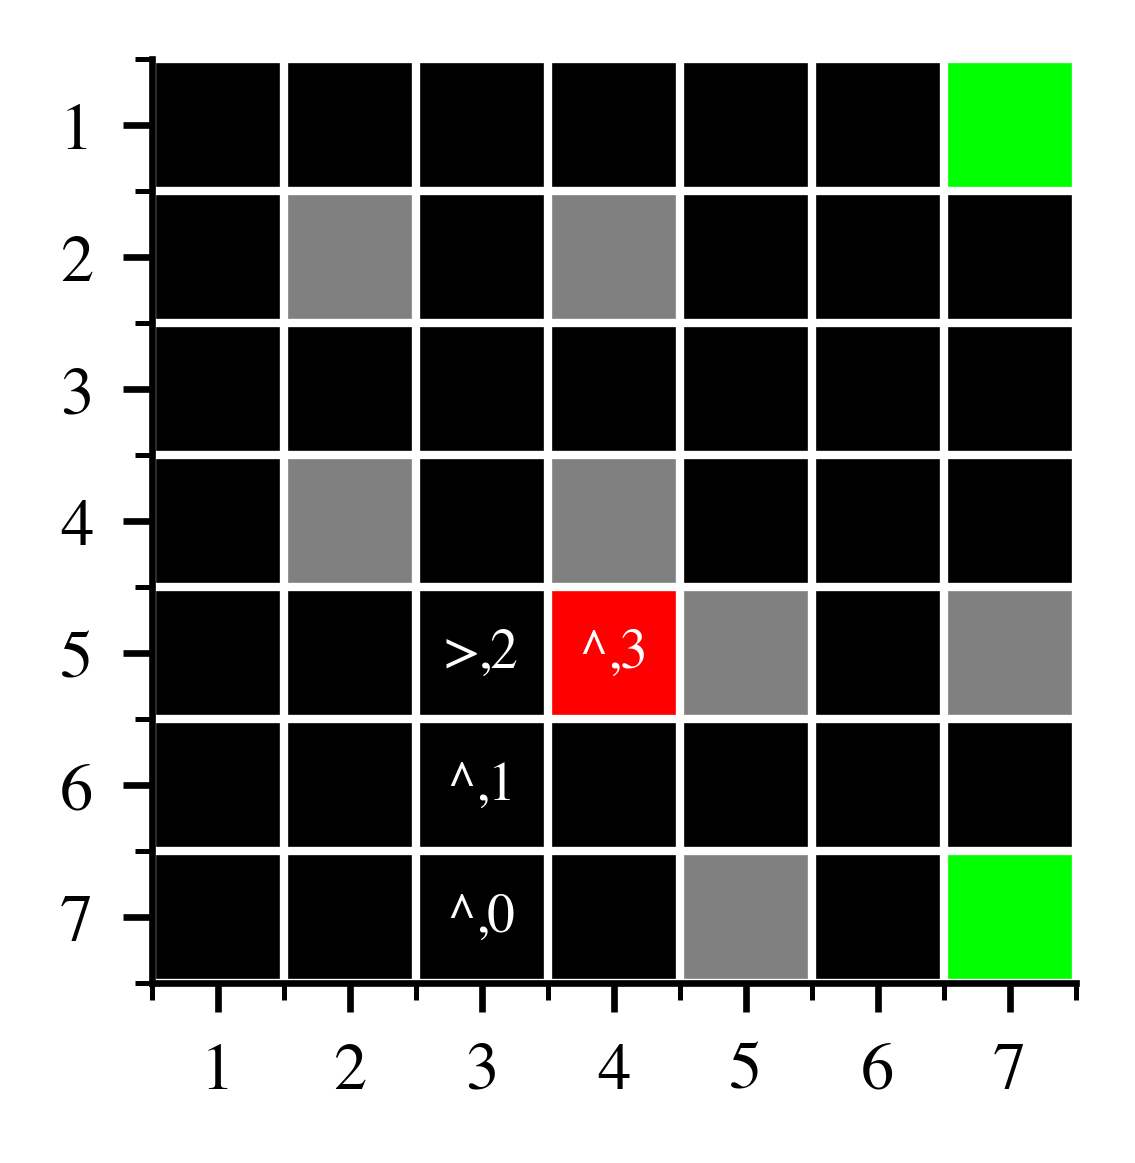

In [7]:
# Plot a trajectory to check if the data has been correctly formed
env.plot_traj(offline_data[-1])

## Sequential Encoder

We use sequential encoder to parse the offline data and create clusters of the trajectories which will be used for attributing the decisions in the later steps.

In [8]:
def tokenizer(trajectories, state_space_dim, action_dict, reward_dict, max_traj_len = 25):
    """
        Tokenizer for capturing gridworld trajectories
    """

    action_space_dim = len(action_dict)
    reward_set_dim = len(reward_dict)
    
    # TOKEN IDs
    # 1 START TOKEN
    # 2 END TOKEN
    # 0 PAD TOKEN
    # STATE TOKENs
    # ACTION TOKENs
    # REWARD TOKENs
    
    complete_traj_tokens = []
    
    for traj in trajectories:
        # Traj contains (s,a,r,s')
        # We generate tokens for 's', 'a' and 'r'
        
        traj_tokens = []
        
        # Start token
        traj_tokens.append(1)
        
        for sars_ in traj:
            s = sars_[0]
            a = sars_[1]
            r = sars_[2]
            
            # State
            traj_tokens.append(3 + s)
            
            # Action
            traj_tokens.append(3 + state_space_dim + a)
            
            # Reward
            traj_tokens.append(3 + state_space_dim + action_space_dim + reward_dict[r])
        
        # Remove action and reward for terminal state, TO BE USED ONLY when (s_terminal, a_random, reward = 0, s_terminal) exists at the end of trajectory data
        traj_tokens.pop()
        traj_tokens.pop()
        
        # End token
        traj_tokens.append(2)
        
        # Pad with zero tokens
        if max_traj_len + 3 - len(traj) > 0:
            traj_tokens = traj_tokens + [0]*(3*(max_traj_len + 3 - len(traj)))
        
        complete_traj_tokens.append(torch.LongTensor(traj_tokens))
    
    return complete_traj_tokens

vocab_size = 3 + env_width*env_height + len(action_dict) + len(reward_dict)

tokenized_data = tokenizer(offline_data, 
                          state_space_dim = env_width*env_height, 
                          action_dict = action_dict, 
                          reward_dict = reward_dict, 
                          max_traj_len = max_traj_len)

In [9]:
class LSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(LSTMEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.token_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, traj):
        embeds = self.token_embeddings(traj)
        o, (h_n, c_n) = self.lstm(embeds.view(len(traj), 1, -1)) # Batch first is false, -> Input shape (L(seq len), N(num seq), H_in(hidden size))
        # The LSTM output contains :
        # o - Outputs of individual cells : shape (L, N, H)
        # h_n - Final hidden state
        # c_n - Final cell state
        return o[-1], (h_n, c_n)
    
class LSTMDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(LSTMDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size,
                                      )

        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, hidden_state, cell_state):
        # Input is START TOKEN
        # Hidden state, Cell state are taken from encoder's output

        # Get embedding
        embedded = self.embedding(input)        
        output = embedded.view(len(input), 1, -1)
        
        # Run LSTM to decode the trajectory
        output, _ = self.lstm(output, (hidden_state, cell_state))
        
        # Convert LSTM logits to vocab size softmax 
        out = self.out(output.squeeze(1))
        output = F.log_softmax(out, dim=1)
        
        return output

class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, traj):
        traj_embedding = self.encoder(traj[1:])
        decoded_traj = self.decoder(traj[:-1], traj_embedding[1][0], traj_embedding[1][1])
        return decoded_traj, traj_embedding

traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)


## Training LSTM to encode trajectories in a seq2seq setting

In [10]:
# Hyperparameters 
num_epochs = 25

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1)

In [11]:
model.train()

for epoch_id, epoch in enumerate(range(num_epochs)):
    total_loss = 0
    for traj_id, traj in enumerate(tokenized_data):
        optimizer.zero_grad()
        
        # Get decoded trajectory and its embedding
        decoded_traj, traj_embedding = model(traj)
        # Loss
        loss = F.nll_loss(decoded_traj.view(-1, vocab_size),
                          traj[1:].contiguous().view(-1),
                          ignore_index=0)
        
        # Optimize the model
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        optimizer.step()
        
        # Record loss
        total_loss += loss.data.item()

    total_loss = total_loss / 100
    
    print(f'Epoch: {epoch_id + 1}, Loss:{total_loss}')

Epoch: 1, Loss:1.11340346544981
Epoch: 2, Loss:0.5122088016569615
Epoch: 3, Loss:0.3917909574881196
Epoch: 4, Loss:0.3165824056789279
Epoch: 5, Loss:0.2592676686123013
Epoch: 6, Loss:0.2183819454908371
Epoch: 7, Loss:0.19150890585035085
Epoch: 8, Loss:0.17201273366808892
Epoch: 9, Loss:0.1587253575026989
Epoch: 10, Loss:0.14653272299095987
Epoch: 11, Loss:0.13742611272260546
Epoch: 12, Loss:0.13037823842838406
Epoch: 13, Loss:0.1249823035672307
Epoch: 14, Loss:0.11977013442665338
Epoch: 15, Loss:0.11483585722744465
Epoch: 16, Loss:0.1119763720780611
Epoch: 17, Loss:0.1080980883911252
Epoch: 18, Loss:0.10567527451552451
Epoch: 19, Loss:0.10390043838880957
Epoch: 20, Loss:0.1015754290111363
Epoch: 21, Loss:0.10098108118399977
Epoch: 22, Loss:0.09863811549730599
Epoch: 23, Loss:0.09720131874084473
Epoch: 24, Loss:0.0958835768327117
Epoch: 25, Loss:0.09479318615980446


In [12]:
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_5.pth')
# torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_fourrooms.pth')
torch.save(model.state_dict(), './ckpt_save_dir/seq2seq_traj_7.pth')

## Trajectory Attribution 

Starts here...

In [13]:
# Load the trained model
traj_encoder = LSTMEncoder(embedding_dim=16, vocab_size= vocab_size, hidden_size=32)
traj_decoder = LSTMDecoder(embedding_size=16, hidden_size=32, vocab_size=vocab_size)

model = Seq2Seq(traj_encoder, traj_decoder)
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_5.pth'))
# model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_fourrooms.pth'))
model.load_state_dict(torch.load('./ckpt_save_dir/seq2seq_traj_7.pth'))

<All keys matched successfully>

### Encode trajectories in the offline dataset

In [14]:
# Load and generate trajectory embeddings
traj_embeddings = []

for traj_id, traj in enumerate(tokenized_data):
    with torch.no_grad():
        decoded_traj, traj_embedding = model(traj)
        traj_embeddings.append(torch.cat(traj_embedding[1], axis=-1).numpy().reshape(-1))
        

### PCA analysis of the trajectory embeddings

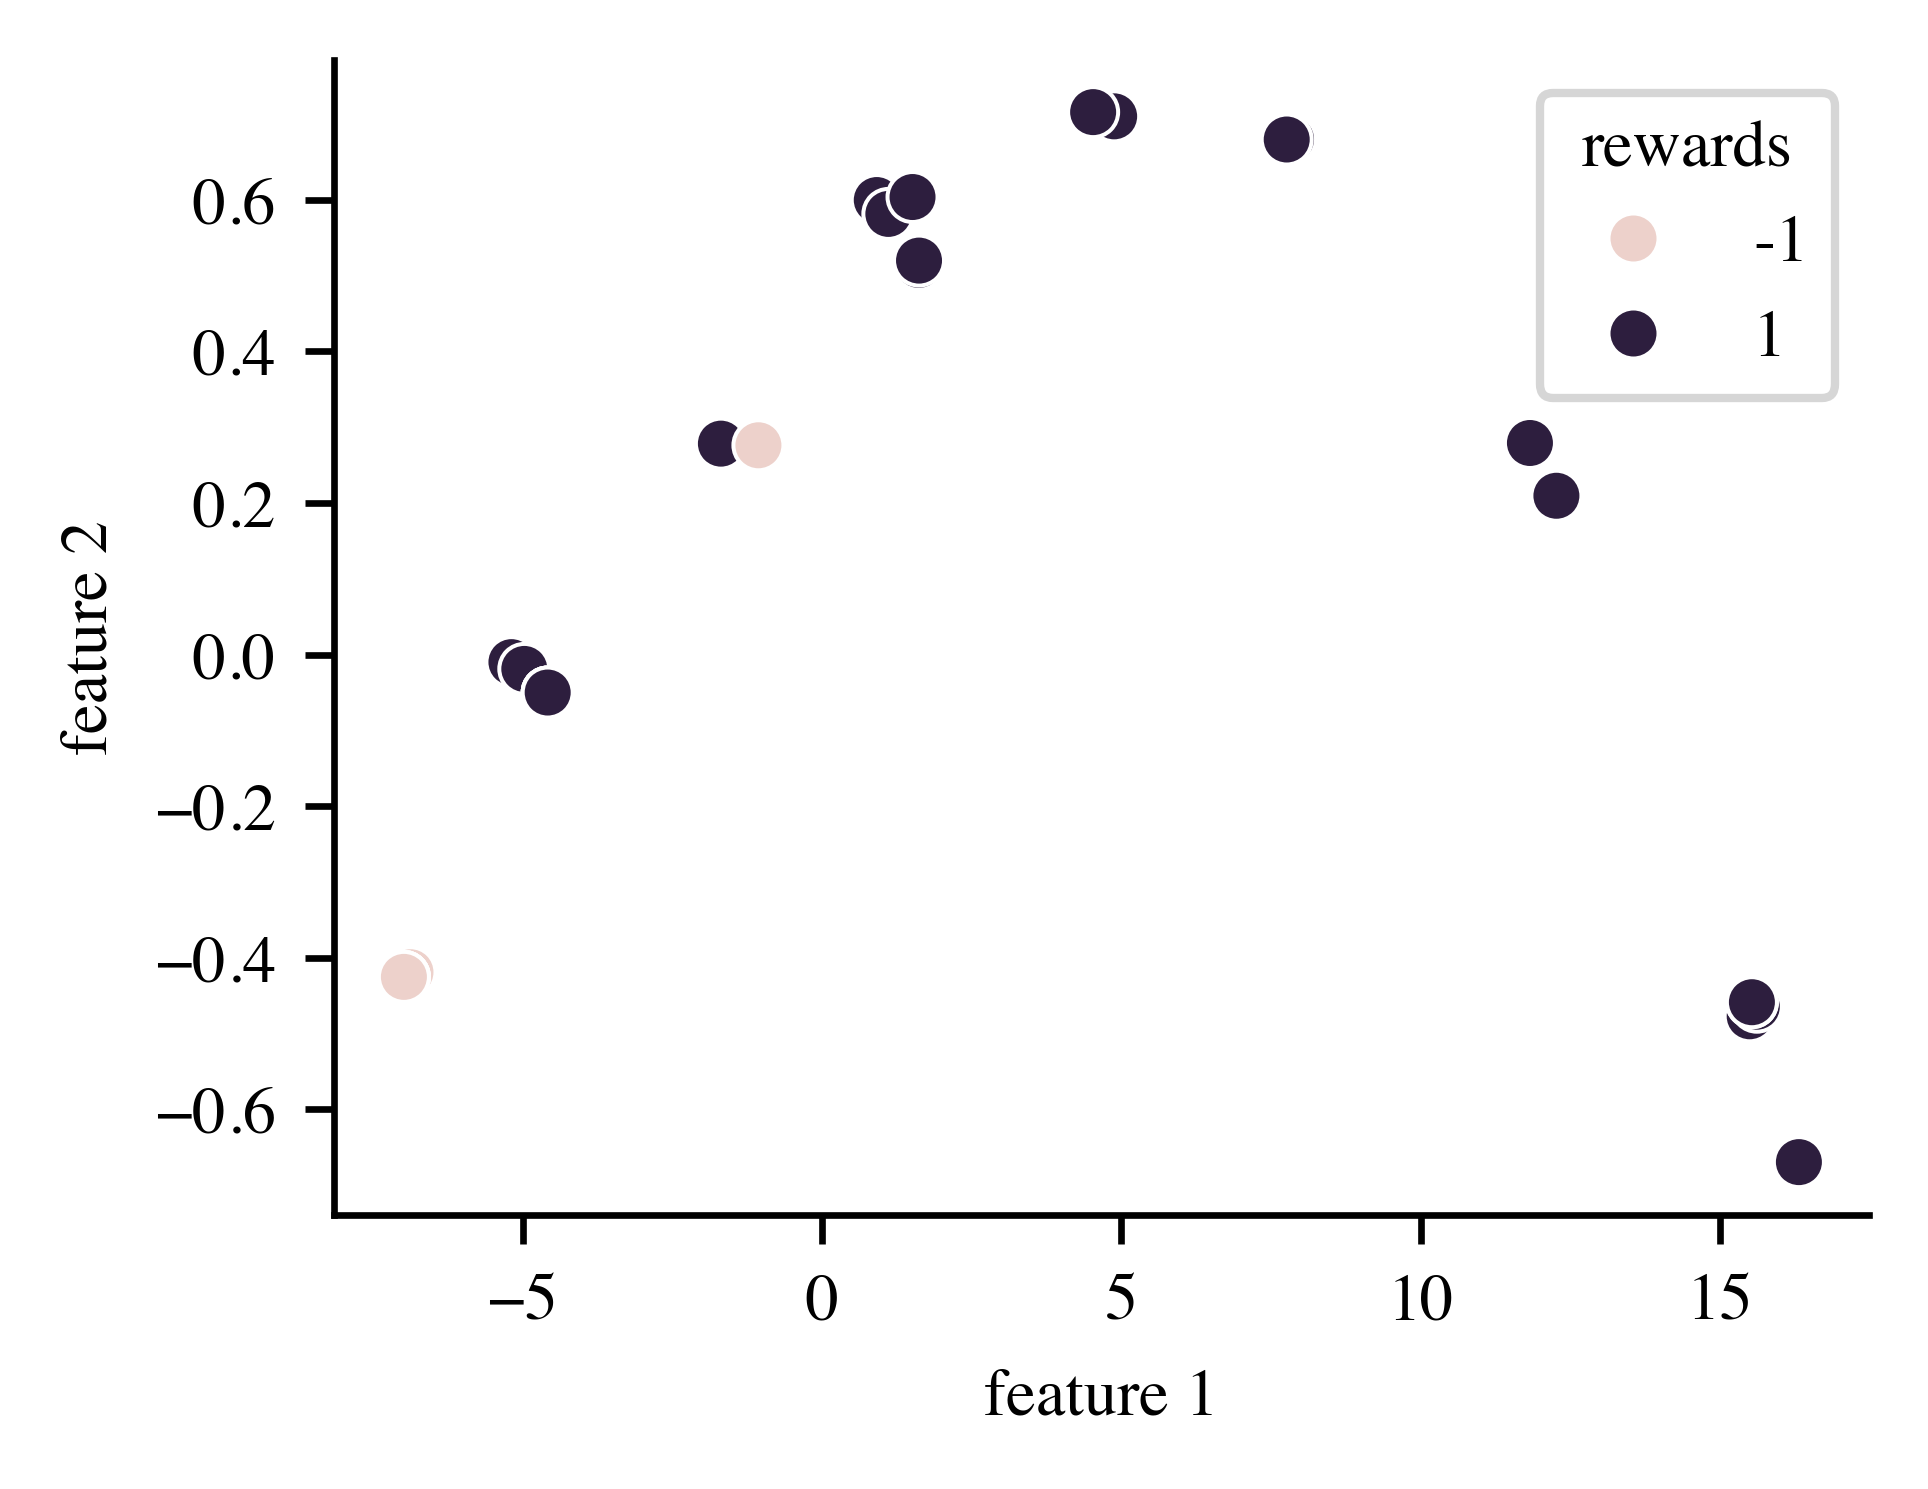

In [15]:
pca = PCA(n_components=2)
pca_traj_embeddings = pca.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeddings[:, 0], 'feature 2': pca_traj_embeddings[:, 1],
                 'rewards': [+1] * num_pos_trajs + [-1] * num_neg_trajs}
df = pd.DataFrame(plotting_data)

plt.figure()
sns.scatterplot(x='feature 1', y='feature 2', hue='rewards', data=df)
# plt.title('PCA: Trajectory Embeddings')
# plt.legend()
plt.show()

# plt.figure()
# data_ax = sns.scatterplot(x='x',
#                           y='y',
#                           hue='labels',
#                           palette='deep',
#                           data=df,
#                           legend=True)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
# plt.title('PCA: Cluster Embeddings using ' + embed_gen_config['method_name'])
# plt.show()

### Clustering of the trajectories using X-Means

In [17]:

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(traj_embeddings, amount_initial_centers, random_seed=3).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 10.
xmeans_instance = xmeans(traj_embeddings, initial_centers, 10, random_seed=3)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
print("Clusters:", clusters)
print('Number of clusters', len(clusters))

Total WCE: 12.071373696385022
Clusters: [[0, 5, 12, 21], [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25], [51, 52, 53, 54, 56, 57, 58, 59], [55], [27, 28, 29, 30, 31, 32, 33, 34, 35], [26, 50], [41], [36, 37, 38, 39], [42, 43, 44, 45, 46, 47, 48, 49], [40]]
Number of clusters 10


In [18]:
# for cluster_id, cluster in enumerate(clusters):
#     print('-'*10)
#     print('Cluster ID', cluster_id)
#     for traj_id in cluster:
#         env.plot_traj(offline_data[traj_id])    
#     print('-'*10)

In [19]:
traj_cluster_labels = np.zeros(len(traj_embeddings), dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for traj_id in cluster:
        traj_cluster_labels[traj_id] = cluster_id


In [20]:
palette = sns.color_palette('husl', len(clusters) + 1)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8836443049112893, 0.5240073524369634, 0.19569304285113343),
 (0.710130687316902, 0.6046852192663268, 0.19426060163712158),
 (0.5432776721247529, 0.6540981095185215, 0.19324494273892204),
 (0.19592059105779686, 0.6981620017487838, 0.3452219818913641),
 (0.2067117296964458, 0.6829103404254792, 0.5829988925822328),
 (0.21420912437215422, 0.6714963557258681, 0.6986206664203177),
 (0.22537170008202412, 0.6531400148480775, 0.841007805313343),
 (0.5596943802099308, 0.5764402169887779, 0.9583930713150347),
 (0.8578978803740231, 0.44058452715322166, 0.957819659566579),
 (0.9628653850704806, 0.4025928454059796, 0.7779310354076443)]

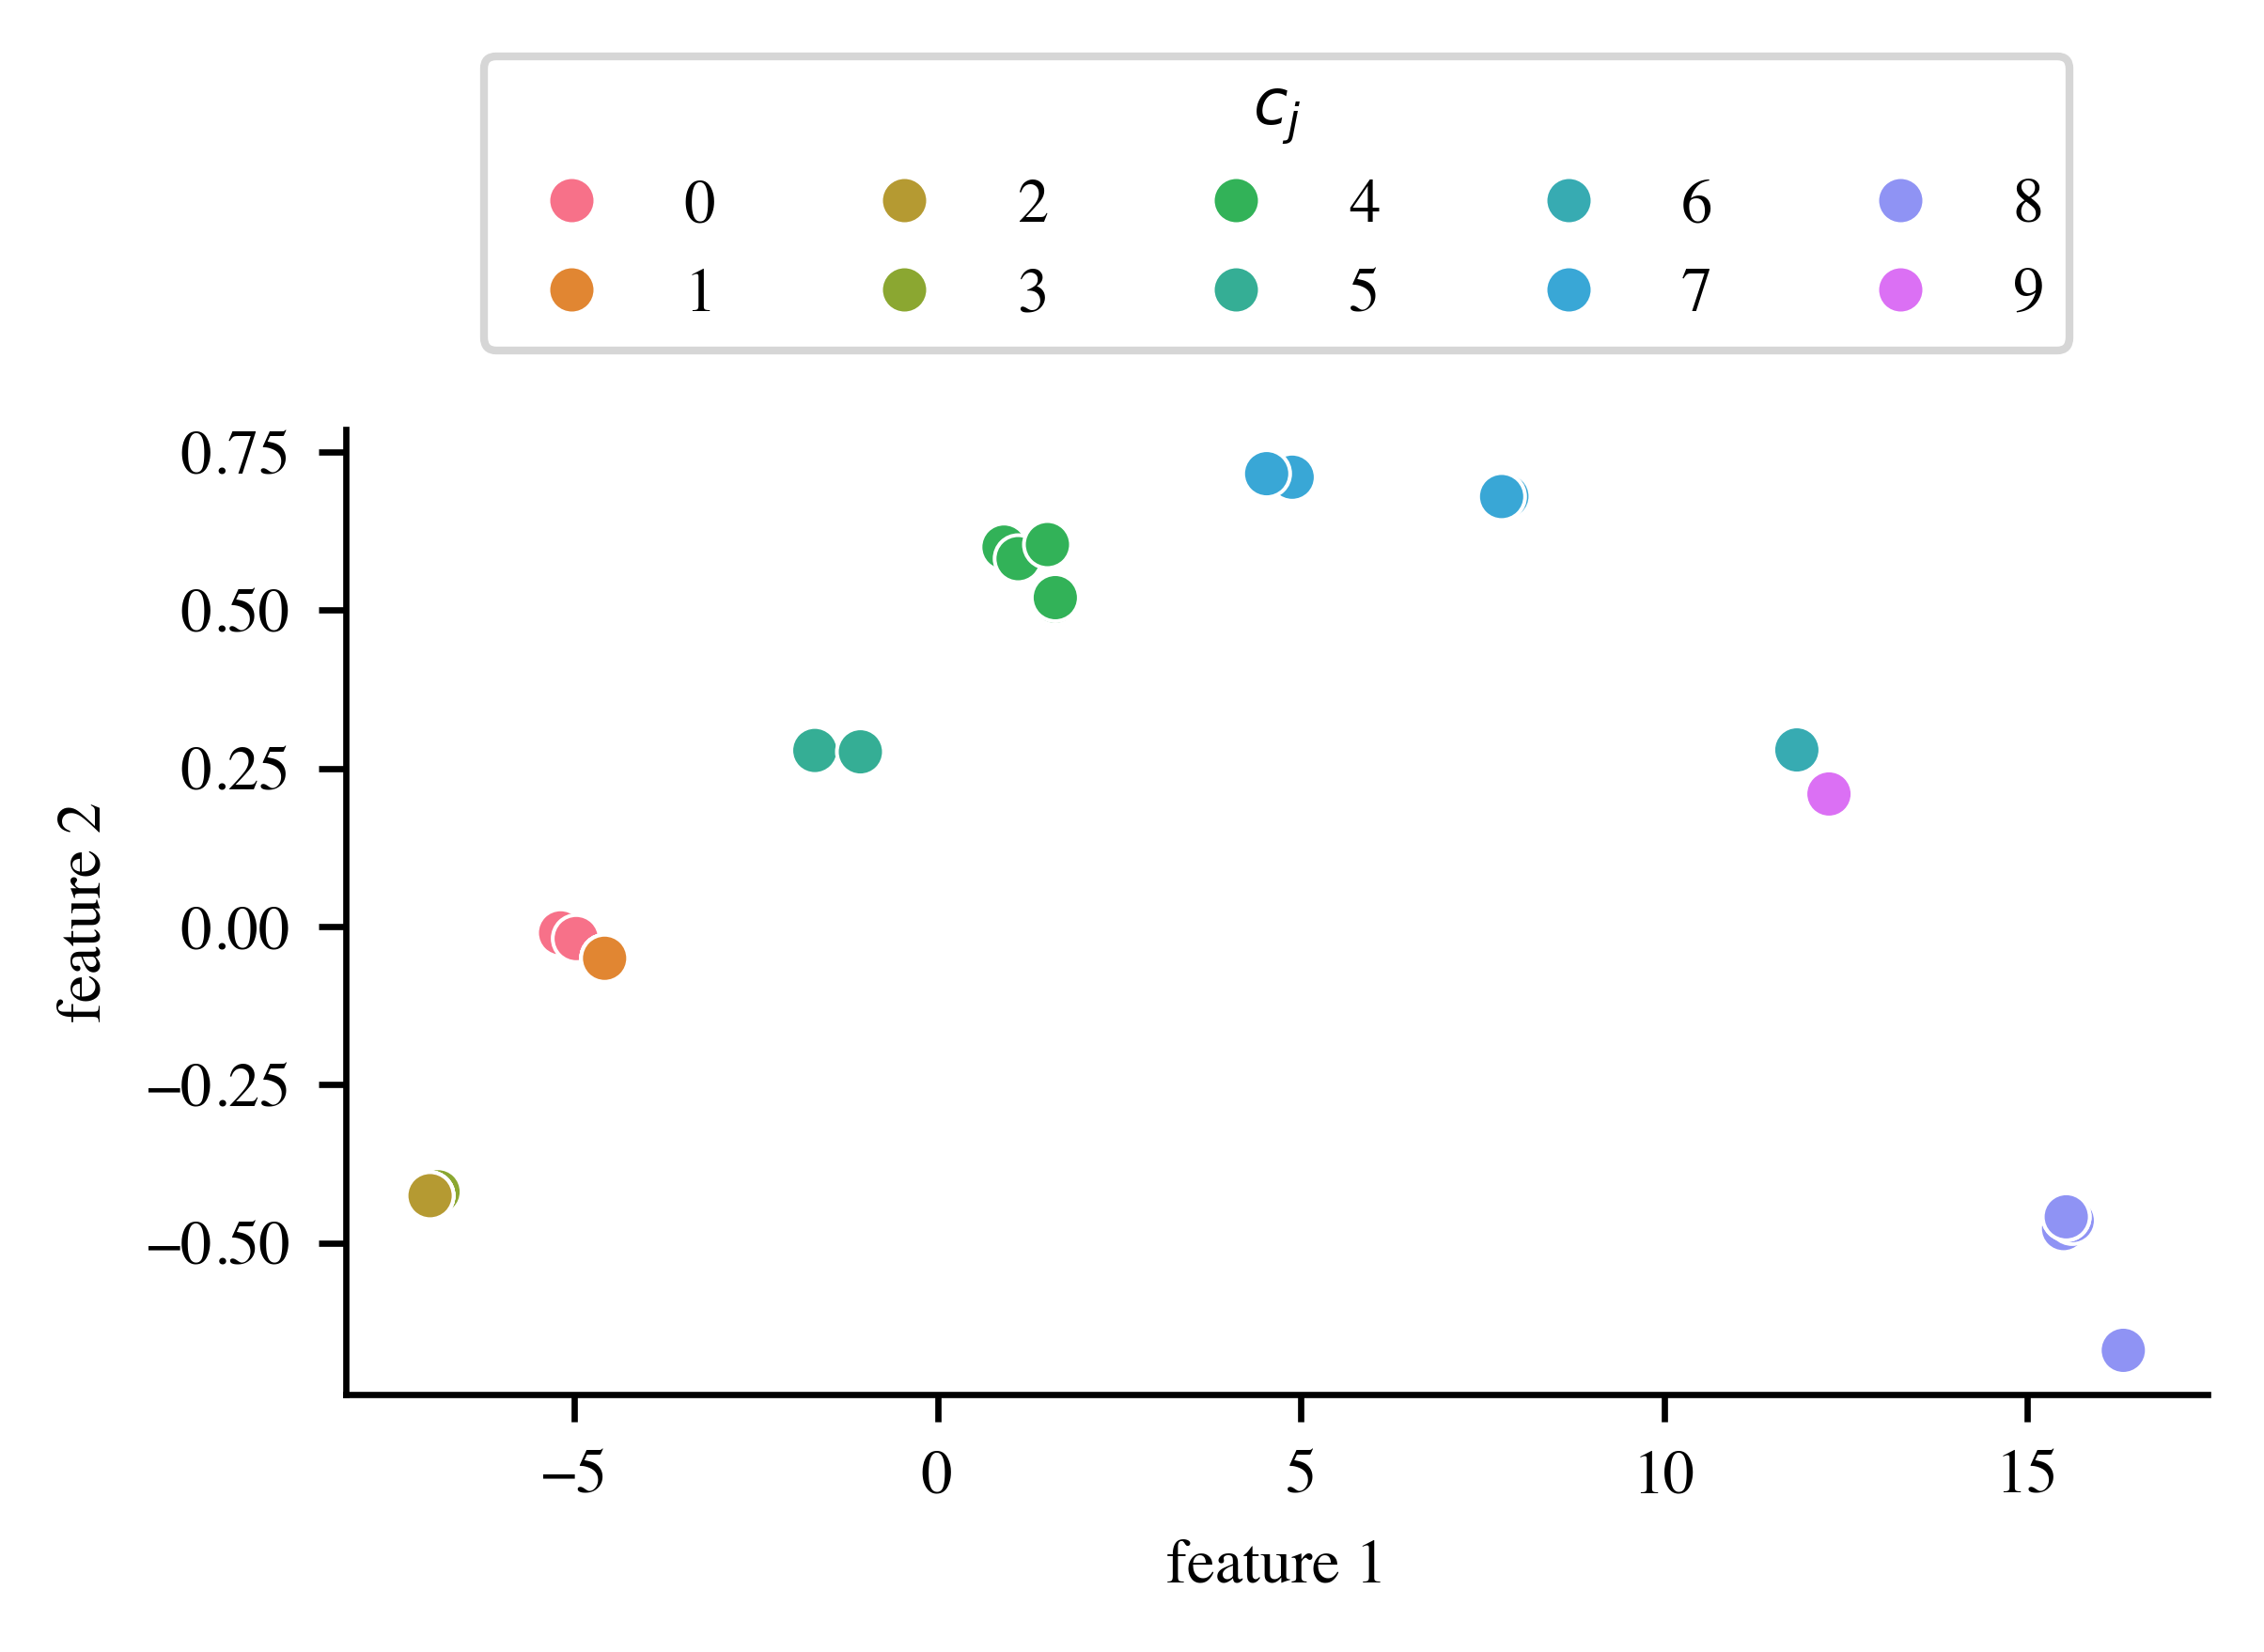

In [21]:
# cluster_data_embeds = [result_data_combinations[cid][1] for cid in result_data_combinations]
# cluster_data_embeds.pop(0)

pca_traj = PCA(n_components=2)
pca_traj_embeds = pca_traj.fit_transform(traj_embeddings)
plotting_data = {'feature 1': pca_traj_embeds[:, 0],
                 'feature 2': pca_traj_embeds[:, 1],
                 'cluster id': traj_cluster_labels}
df = pd.DataFrame(plotting_data)

plt.figure(figsize=(4,3))
data_ax = sns.scatterplot(x='feature 1',
                          y='feature 2',
                          hue='cluster id',
                          palette=palette[:len(clusters)],
                          data=df,
                          legend=True)
plt.legend(title = '$c_{j}$', loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5)
# plt.legend(title = '$c_{j}$', loc='center left', bbox_to_anchor=(1., 0.7), ncol=2)
# for cid, _ in enumerate(cluster_data_embeds):
#     data_ax.text(pca_data_embeds[:, 0][cid],
#                  pca_data_embeds[:, 1][cid],
#                  str(cid),
#                  horizontalalignment='left',
#                  size='medium',
#                  color='black',
#                  weight='semibold')
plt.tight_layout()
plt.savefig('./traj_clustering_grid.pdf')
plt.show()

## Encode sets of trajectories

In [22]:
def get_data_embedding(traj_embeddings):
#     return np.exp(np.abs(np.array(traj_embeddings).sum(axis=0)/100.))/np.sum(np.abs(np.exp(np.array(traj_embeddings).sum(axis=0)/100.)))
    return np.exp(np.array(traj_embeddings).sum(axis=0)/10.)/np.sum(np.exp(np.array(traj_embeddings).sum(axis=0)/10.))

data_embedding = get_data_embedding(traj_embeddings)

### Train models on different cluster combinations

In [23]:
transition_model, reward_model = generate_model(env, offline_data)
values, action_values, policy = dp(env, transition_model, reward_model, gamma=0.95, threshold=1e-4)

In [24]:
result_data_combinations = {0:(action_values, data_embedding)}
cluster_embeddings = {}

for cluster_id, cluster in enumerate(clusters):
    temp_data = []
    temp_traj_embeds = []
    temp_cluster_traj_embeds = []
    for traj_id, traj in enumerate(offline_data):
        if traj_id not in cluster:
            temp_data.append(offline_data[traj_id])
            temp_traj_embeds.append(traj_embeddings[traj_id])
        else:
            temp_cluster_traj_embeds.append(traj_embeddings[traj_id])
            
    # Generate the data embedding
    data_embedding_new = get_data_embedding(temp_traj_embeds)
    
    # Generate cluster embedding
    cluster_embedding = get_data_embedding(temp_cluster_traj_embeds)
    
    # Train an agent on the new data
    transition_model_new, reward_model_new = generate_model(env, temp_data)
    values_new, action_values_new, policy_new = dp(env,
                                                   transition_model_new,
                                                   reward_model_new,
                                                   gamma=0.95,
                                                   threshold=1e-4)
    
    # Collect the data embedding and the trajectory
    result_data_combinations[cluster_id + 1] = (action_values_new, data_embedding_new)
    cluster_embeddings[cluster_id] = cluster_embedding

### Generate attributions

In [25]:
attributions = []

for state in range(np.prod(env.dim)):
    
    if (state//env_width, state%env_width) in env.terminals:
        continue
        
    orig_state_action_values = action_values[state]
    orig_opt_state_actions = np.where(orig_state_action_values == np.max(orig_state_action_values))[0]

    distances = []
    new_actions = []
    for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items():
        new_state_action_values = action_values_new[state]
        new_opt_state_actions = np.where(new_state_action_values == np.max(new_state_action_values))[0]

        if list(new_opt_state_actions) != list(orig_opt_state_actions):
            w_d = wasserstein_distance(data_embedding, data_embedding_new)
        else:
            w_d = 1e9
        
        distances.append(w_d)
        new_actions.append(new_opt_state_actions)
    
    responsible_data_combination = np.argsort(distances)[0]
    
    if distances[responsible_data_combination] == 1e9 or distances[responsible_data_combination] == 0:
        continue
    
    print('-'*10)
    print(f'State - {state%env_width + 1, state//env_width + 1}')
    print(f'Distance - {distances[responsible_data_combination]}')
    print(f'Original Actions -{[action_dict[orig_action] for orig_action in orig_opt_state_actions]}')
    print(f'New Action - {[action_dict[new_action] for new_action in new_actions[responsible_data_combination]]}')

    print(f'Responsible data combination - data id {responsible_data_combination}')
    print(f'Responsible trajectory id {clusters[responsible_data_combination - 1]}')
    if len(clusters[responsible_data_combination - 1]):
        cid_list = list(range(len(clusters)))
        cid_list.pop(responsible_data_combination - 1)
        alternate_cid = np.random.choice(cid_list)
        attributions.append({
            'state' : (state%env_width + 1, state//env_width + 1),
            'orig_act': [action_dict[orig_action] for orig_action in orig_opt_state_actions],
            'new_act': [action_dict[new_action] for new_action in new_actions[responsible_data_combination]],
            'attributed_trajs':clusters[responsible_data_combination - 1],
            'random_baseline_trajs': list(np.random.randint(0, len(offline_data), 5)),
            'alternate_cluster_trajs': clusters[alternate_cid - 1],
            'responsible_cluster': responsible_data_combination - 1
        })
#         for traj in clusters[responsible_data_combination - 1]:
#             env.plot_traj(offline_data[traj])
    print('-'*10)

----------
State - (1, 1)
Distance - 5.443173336061591e-06
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 9
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (2, 1)
Distance - 5.443173336061591e-06
Original Actions -['RIGHT']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 9
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (1, 2)
Distance - 5.443173336061591e-06
Original Actions -['UP']
New Action - ['LEFT', 'UP', 'RIGHT', 'DOWN']
Responsible data combination - data id 9
Responsible trajectory id [42, 43, 44, 45, 46, 47, 48, 49]
----------
----------
State - (5, 2)
Distance - 8.049639745877357e-07
Original Actions -['UP']
New Action - ['RIGHT']
Responsible data combination - data id 7
Responsible trajectory id [41]
----------
----------
State - (1, 3)
Distance - 8.049639745877357e-07
Original Actions -['UP']


In [26]:
attributions

[{'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [20, 40, 1, 32, 52],
  'alternate_cluster_trajs': [51, 52, 53, 54, 56, 57, 58, 59],
  'responsible_cluster': 8},
 {'state': (2, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [36, 22, 17, 24, 42],
  'alternate_cluster_trajs': [55],
  'responsible_cluster': 8},
 {'state': (1, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [34, 31, 21, 41, 0],
  'alternate_cluster_trajs': [41],
  'responsible_cluster': 8},
 {'state': (5, 2),
  'orig_act': ['UP'],
  'new_act': ['RIGHT'],
  'attributed_trajs': [41],
  'random_baseline_trajs': [29, 31, 2, 37, 46],
  'alternate_cluster_trajs': [36, 37, 38, 39],
  'responsib

In [27]:
results_save_dir = './gridworld_results/grid_7by7/'
if not os.path.exists(results_save_dir):
    os.makedirs(results_save_dir)


# for traj_id, traj in enumerate(offline_data):
#     env.plot_traj(traj, path=os.path.join(results_save_dir, 'traj_' + str(traj_id) + '.png'))


In [28]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [29]:
# Data to save
data_to_be_saved = [
    {
        'attributions' : attributions,
    }
]

dumped = json.dumps(data_to_be_saved, cls=NumpyEncoder)

with open(os.path.join(results_save_dir, 'attribution_results.json'), 'w') as f:
    json.dump(dumped, f)

In [30]:
attributions

[{'state': (1, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [20, 40, 1, 32, 52],
  'alternate_cluster_trajs': [51, 52, 53, 54, 56, 57, 58, 59],
  'responsible_cluster': 8},
 {'state': (2, 1),
  'orig_act': ['RIGHT'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [36, 22, 17, 24, 42],
  'alternate_cluster_trajs': [55],
  'responsible_cluster': 8},
 {'state': (1, 2),
  'orig_act': ['UP'],
  'new_act': ['LEFT', 'UP', 'RIGHT', 'DOWN'],
  'attributed_trajs': [42, 43, 44, 45, 46, 47, 48, 49],
  'random_baseline_trajs': [34, 31, 21, 41, 0],
  'alternate_cluster_trajs': [41],
  'responsible_cluster': 8},
 {'state': (5, 2),
  'orig_act': ['UP'],
  'new_act': ['RIGHT'],
  'attributed_trajs': [41],
  'random_baseline_trajs': [29, 31, 2, 37, 46],
  'alternate_cluster_trajs': [36, 37, 38, 39],
  'responsib

# Distant Trajectories influence Decisions of the Agents

Distant trajectories influencing agents decision can be found by plotting attributed trajectories for a state.
Uncomment the lines in next cell to see results.

In [35]:
# ## for state (1,1)
# for i in range(len(attributions[0]['attributed_trajs'])):
#     env.plot_traj(offline_data[attributions[0]['attributed_trajs'][i]])


## Initial State Value Estimates

In [ ]:
for data_combination_id in result_data_combinations:
    print(result_data_combinations[data_combination_id][0].max(axis=1).mean())

0.3060659590252144
0.3055496351030881
0.3053346838155589
0.3049450825261877
0.30552637572273367
0.30536274022365273
0.29909836699615666
0.2848673684907365
0.30554721358645454
0.30573512576298323
0.30458490316462566


## Average delta q

In [ ]:
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    print(np.sum(np.abs(action_values_new - result_data_combinations[0][0]))/(env_width*env_height))

0.0
0.0011976953983500707
0.0016168924761831062
0.002828528795376404
0.021967430403267173
0.03999245661340688
0.031577816855728115
0.0721380120142425
0.01288157720139745
0.02892113568830871
0.017515916135823567


## Compare the actions

In [ ]:
action_comparison = {}
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    action_comparison[data_combination_id] = 0
    for i in range(env_width*env_height):
            orig_actions = np.where(result_data_combinations[0][0][i] == np.max(result_data_combinations[0][0][i]))[0]
            alternate_actions = np.where(result_data_combinations[data_combination_id][0][i] == np.max(result_data_combinations[data_combination_id][0][i]))[0]
            
            if list(orig_actions) == list(alternate_actions):
                action_comparison[data_combination_id] += 1 
#             alternate_actions = 
#     print(np.sum(np.argmax(action_values_new, axis=1) != np.argmax(result_data_combinations[0][0], axis=1))/(env_width*env_height))

In [ ]:
np.array(list(action_comparison.values()))/(env_width*env_height)

array([1.        , 0.95918367, 0.95918367, 0.87755102, 1.        ,
       0.87755102, 0.95918367, 0.83673469, 0.97959184, 0.97959184,
       0.85714286])

## Data distances

In [ ]:
data_distances = np.zeros(len(result_data_combinations))
for data_combination_id, (action_values_new, data_embedding_new) in result_data_combinations.items(): 
    data_distances[data_combination_id] = wasserstein_distance(data_embedding, data_embedding_new)

In [ ]:
with np.printoptions(precision=5, suppress=True):
    print((data_distances - data_distances.min()) / (data_distances.max() - data_distances.min()))

[0.      1.      0.00848 0.07413 0.00229 0.00467 0.00214 0.00413 0.00064
 0.00096 0.00061]


## Cluster Attribution Frequency

In [ ]:
cluster_attr_freq = np.zeros(len(clusters))

In [ ]:
for attribution in attributions:
    cluster_attr_freq[attribution['responsible_cluster']] += 1 

In [ ]:
cluster_attr_freq/cluster_attr_freq.sum()

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.125, 0.375, 0.   , 0.   ,
       0.5  ])